In [1]:
import umap
from sklearn.svm import OneClassSVM

import os
import pandas as pd
from PIL import Image, ImageOps
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from natsort import natsorted

import tensorflow_addons as tfa

import cv2
import shutil
import glob

import tensorflow as tf
from tensorflow.keras import layers, models, Input

import sklearn

from skimage.transform import resize

base_dir = "/home/lingfeng/Downloads/LC25000/lung_colon_image_set/lung_image_sets"

normal_dir = os.path.join(base_dir, "lung_n")
lung_aca_dir = os.path.join(base_dir, "lung_aca")
lung_scc_dir = os.path.join(base_dir, "lung_scc")

def dataset_collection_func():

    normal_filepaths = []
    normal_labels = []

    abnormal_filepaths = []
    abnormal_labels = []

    train_filepaths=[]
    train_labels=[]
    test_filepaths=[]
    test_labels=[]

    np.random.seed(1234) # set seed

    for tissue_slice in tqdm(natsorted(os.listdir(normal_dir))):
        tissue_slice_path = os.path.join(normal_dir, tissue_slice)
        normal_filepaths.append(tissue_slice_path)
        normal_labels.append('No')

    for tissue_slice in tqdm(natsorted(os.listdir(lung_aca_dir))):
        tissue_slice_path = os.path.join(lung_aca_dir, tissue_slice)
        abnormal_filepaths.append(tissue_slice_path)
        abnormal_labels.append('Yes')
        
    for tissue_slice in tqdm(natsorted(os.listdir(lung_scc_dir))):
        tissue_slice_path = os.path.join(lung_scc_dir, tissue_slice)
        abnormal_filepaths.append(tissue_slice_path)
        abnormal_labels.append('Yes')

    normal_filepaths = np.array(normal_filepaths)
    normal_labels = np.array(normal_labels)

    abnormal_filepaths = np.array(abnormal_filepaths)
    abnormal_labels = np.array(abnormal_labels)
    
    # normal
    idx = np.random.permutation(len(normal_labels))
    normal_filepaths = normal_filepaths[idx]
    normal_labels = normal_labels[idx]

    train_test_ratio = 0.8

    train_normal_filepaths = normal_filepaths[:int(train_test_ratio*len(normal_filepaths))]
    train_normal_labels = normal_labels[:int(train_test_ratio*len(normal_labels))]

    test_normal_filepaths = normal_filepaths[int(train_test_ratio*len(normal_filepaths)):]
    test_normal_labels = normal_labels[int(train_test_ratio*len(normal_labels)):]

    train_validation_ratio = 0.8

    new_train_normal_filepaths = train_normal_filepaths[:int(train_validation_ratio*len(train_normal_filepaths))]

    validation_normal_filepaths = train_normal_filepaths[int(train_validation_ratio*len(train_normal_filepaths)):]
    validation_normal_labels = train_normal_labels[int(train_validation_ratio*len(train_normal_labels)):]

    # abnormal
    idx = np.random.permutation(len(abnormal_labels))
    abnormal_filepaths = abnormal_filepaths[idx]
    abnormal_labels = abnormal_labels[idx]

    train_abnormal_filepaths = abnormal_filepaths[:int(train_test_ratio*len(abnormal_filepaths))]
    train_abnormal_labels = abnormal_labels[:int(train_test_ratio*len(abnormal_labels))]

    test_abnormal_filepaths = abnormal_filepaths[int(train_test_ratio*len(abnormal_filepaths)):]
    test_abnormal_labels = abnormal_labels[int(train_test_ratio*len(abnormal_labels)):]

    new_train_abnormal_filepaths = train_abnormal_filepaths[:int(train_validation_ratio*len(train_abnormal_filepaths))]
    new_train_abnormal_labels = train_abnormal_labels[:int(train_validation_ratio*len(train_abnormal_labels))]

    validation_abnormal_filepaths = train_abnormal_filepaths[int(train_validation_ratio*len(train_abnormal_filepaths)):]
    validation_abnormal_labels = train_abnormal_labels[int(train_validation_ratio*len(train_abnormal_labels)):]

    train_filepaths = new_train_normal_filepaths

    validation_filepaths = np.concatenate((validation_normal_filepaths,validation_abnormal_filepaths),axis=0)
    validation_labels = np.concatenate((validation_normal_labels,validation_abnormal_labels),axis=0)

    test_filepaths = np.concatenate((test_normal_filepaths,test_abnormal_filepaths),axis=0)
    test_labels = np.concatenate((test_normal_labels,test_abnormal_labels),axis=0)

    validation_labels = np.where(validation_labels=='No', 0, 1)
    test_labels = np.where(test_labels=='No', 0, 1)

    return train_filepaths, validation_filepaths, validation_labels, test_filepaths, test_labels

train_filepaths, validation_filepaths, validation_labels, test_filepaths, test_labels = dataset_collection_func()

# image_shape = (256,256,3)
image_shape = (224,224,3)

def get_image(img_path):
    img_array = Image.open(img_path)
    img_array.load()
    img_array = img_array.resize((image_shape[0],image_shape[1]))
    img_array = np.asarray(img_array).astype(np.float32)
    # print("img_array.shape:", img_array.shape)

#     img_array = img_array / 255.

    return img_array

pretrained_model_encoder = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=image_shape),
        tf.keras.applications.MobileNet(include_top=False, input_shape=image_shape, weights='imagenet'),
        tf.keras.layers.GlobalAveragePooling2D()
    ]
)

pretrained_model_encoder.trainable = False

templates = 1000

X = []
for tissue_slice in tqdm(range(templates)):
    inputs = get_image(train_filepaths[tissue_slice])
    
    inputs = np.expand_dims(inputs, axis=0)
    # training pre-processing
    pretrained_model_encoder_features = pretrained_model_encoder(inputs, training=False)

    pretrained_model_encoder_features = np.array(pretrained_model_encoder_features)
    pretrained_model_encoder_features = np.squeeze(pretrained_model_encoder_features)

    X.append(pretrained_model_encoder_features)

X = np.array(X)



100%|██████████| 1000/1000 [00:20<00:00, 47.66it/s]


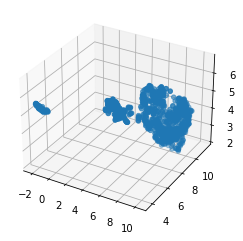

In [2]:
umap_model = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1).fit(X)

embeddings = umap_model.transform(X)

clf = OneClassSVM(nu=0.03).fit(embeddings)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = embeddings[:,2]
xdata = embeddings[:,0]
ydata = embeddings[:,1]
ax.scatter3D(xdata, ydata, zdata);

In [3]:
X_val = []
for tissue_slice in tqdm(range(len(validation_filepaths))):
    inputs = get_image(validation_filepaths[tissue_slice])
    
    inputs = np.expand_dims(inputs, axis=0)
    
    # validation pipeline
    pretrained_model_encoder_features = pretrained_model_encoder(inputs, training=False)

    pretrained_model_encoder_features = np.array(pretrained_model_encoder_features)
    pretrained_model_encoder_features = np.squeeze(pretrained_model_encoder_features)
    
    X_val.append(pretrained_model_encoder_features)
    
X_val = np.array(X_val)

100%|██████████| 2400/2400 [00:43<00:00, 55.48it/s]


In [4]:
embeddings = umap_model.transform(X_val)

y_prob = clf.decision_function(embeddings)
y_pred = clf.predict(embeddings)

y_prob = np.array(y_prob)
y_pred = np.array(y_pred)

y_pred = (y_pred - 1) / -2
y_pred = y_pred.astype(int)

y_prob = np.squeeze(y_prob)
y_pred = np.squeeze(y_pred)

def my_metrics(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)

    y_pred = np.where(y_pred >= 0.5, 1, 0)

    TP, TN, FP, FN = 0, 0, 0, 0
    for prediction, y in zip(y_pred, y_true):

        if(prediction == y):
            if(prediction == 1): # {'Normal': 0, 'Abnormal': 1}
                TP += 1
            else:
                TN += 1
        else:
            if(prediction == 1):
                FP += 1
            else:
                FN += 1

    precision = TP/(TP+FP+1.0e-4)

    recall = TP/(TP+FN+1.0e-4)

    f_measure = (2. * precision * recall)/(precision + recall + 1.0e-4)

    accuracy = (TP + TN) / (TP + TN + FP + FN+1.0e-4)

    return np.array([TP, TN, FP, FN, precision, recall, f_measure, accuracy])

metric_results = my_metrics(validation_labels, y_pred)
auc_roc = sklearn.metrics.roc_auc_score(validation_labels, y_prob)

print("TP:", metric_results[0])
print("TN:", metric_results[1])
print("FP:", metric_results[2])
print("FN:", metric_results[3])

print("precision:", metric_results[4])
print("recall:", metric_results[5])
print("f_measure:", metric_results[6])
print("accuracy:", metric_results[7])
print("auc_roc:", auc_roc)

TP: 1154.0
TN: 712.0
FP: 88.0
FN: 446.0
precision: 0.9291464630316858
recall: 0.7212499549218778
f_measure: 0.8120548912288279
accuracy: 0.777499967604168
auc_roc: 0.07745390625


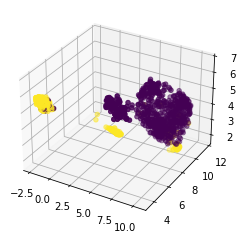

In [5]:
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = embeddings[:,2]
xdata = embeddings[:,0]
ydata = embeddings[:,1]
ax.scatter3D(xdata, ydata, zdata, c=validation_labels);

In [7]:
ax.figure.savefig('lung_validation_feature_dim.png')